# Stereoisomer testing on ChiENN - valenztautomerie

## Importing section

In [97]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import sys

sys.path.append("../../../../")

from ptgnn.features.chienn.mol_to_data import mol_to_data
from ptgnn.features.chienn.molecule3d import smiles_to_3d_mol
from ptgnn.transform import edge_graph_transform

## Define SMILES strings

In [98]:
smiles_list = [
    "C1=CC=CC=CC=C1",
    "C1C=CC=CC=CC=1",
    "C12C=CC=CC1C=C2",
    
    "C1C=CC(Cl)=CC=C(Cl)C=1",
    "C1C=CC=C(Cl)C=CC(Cl)=1",
]

## Visualize and confirm stereomer classification (E/Z)

In [99]:
def showAndChiral(smiles):
    mol = Chem.MolFromSmiles(smiles)
    display(mol)
    print(AllChem.FindMolChiralCenters(mol))
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
            print("Bond", bond.GetIdx(), "stereo:", bond.GetStereo())

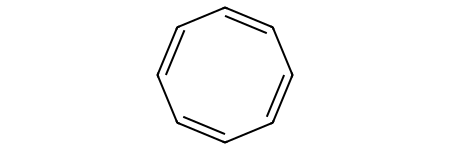

[]
Bond 0 stereo: STEREONONE
Bond 2 stereo: STEREONONE
Bond 4 stereo: STEREONONE
Bond 6 stereo: STEREONONE


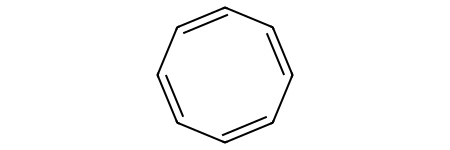

[]
Bond 1 stereo: STEREONONE
Bond 3 stereo: STEREONONE
Bond 5 stereo: STEREONONE
Bond 7 stereo: STEREONONE


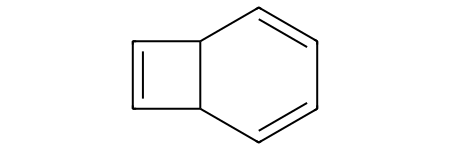

[]
Bond 1 stereo: STEREONONE
Bond 3 stereo: STEREONONE
Bond 6 stereo: STEREONONE


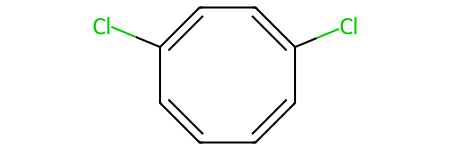

[]
Bond 1 stereo: STEREONONE
Bond 4 stereo: STEREONONE
Bond 6 stereo: STEREONONE
Bond 9 stereo: STEREONONE


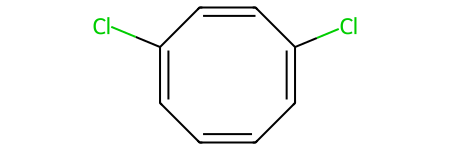

[]
Bond 1 stereo: STEREONONE
Bond 3 stereo: STEREONONE
Bond 6 stereo: STEREONONE
Bond 9 stereo: STEREONONE


In [100]:
for smile in smiles_list:
    showAndChiral(smile)

##  Convert to (edge) graph with ptree

In [101]:
# get molecules
mol_list = [
    smiles_to_3d_mol(
        smiles,
        max_number_of_attempts=100,
        max_number_of_atoms=100
    )
    for smiles in smiles_list
]

In [102]:
data_list = [
    mol_to_data(mol)
    for mol in mol_list
]

In [103]:
data_list = [
    edge_graph_transform(
        data,
        transformation_mode="permutation_tree",
        mol=mol,
        transformation_parameters={
            'k':  3,
            'tetrahedral_chiral': True,
            'chiral_center_selective': False,
            'chiral_center_select_potential': False,
        }
    )
    for data, mol in zip(data_list, mol_list)
]

In [104]:
for data in data_list:
    print(data)
    print(data.ptree)

Data(x=[32, 93], edge_index=[2, 80], edge_attr=[80, 57], pos=[32, 6], parallel_node_index=[32], circle_index=[32], ptree=[32], initial_map=[112], layer0_order_matrix=[1], layer0_type_mask=[1], layer0_pooling=[1], num_layer=2, layer1_order_matrix=[1], layer1_type_mask=[1], layer1_pooling=[1])
['{"S": [0, 1, {"Z": [3, 5]}]}', '{"S": [1, 0, {"Z": [7, 9]}]}', '{"S": [2, 3, {"Z": [1, 5]}]}', '{"S": [3, 2, {"Z": [26, 31]}]}', '{"S": [4, 5, {"Z": [1, 3]}]}', '{"S": [5, 4]}', '{"S": [6, 7, {"Z": [0, 9]}]}', '{"S": [7, 6, {"Z": [11, 13]}]}', '{"S": [8, 9, {"Z": [0, 7]}]}', '{"S": [9, 8]}', '{"S": [10, 11, {"Z": [6, 13]}]}', '{"S": [11, 10, {"Z": [15, 17]}]}', '{"S": [12, 13, {"Z": [6, 11]}]}', '{"S": [13, 12]}', '{"S": [14, 15, {"Z": [10, 17]}]}', '{"S": [15, 14, {"Z": [19, 21]}]}', '{"S": [16, 17, {"Z": [10, 15]}]}', '{"S": [17, 16]}', '{"S": [18, 19, {"Z": [14, 21]}]}', '{"S": [19, 18, {"Z": [23, 25]}]}', '{"S": [20, 21, {"Z": [14, 19]}]}', '{"S": [21, 20]}', '{"S": [22, 23, {"Z": [18, 25]}]}

## Create Model

In [105]:
import torch
from ptgnn.model.modules.custom_wrapper import CustomWrapper
from ptgnn.model.modules.ptree.advanced_tree_layer import AdvancedPermutationTreeLayer

k = 3

modules_list = [
    CustomWrapper(AdvancedPermutationTreeLayer(
        hidden_dim=93,
        k=k,
        apply_p_elu=True
    ))
    for _ in range(2)
] + [
    AdvancedPermutationTreeLayer(
        hidden_dim=93,
        k=k,
        apply_p_elu=True
    )
]

model = torch.nn.Sequential(
    *modules_list
)
model

Sequential(
  (0): CustomWrapper(
    (layer_to_wrap): AdvancedPermutationTreeLayer(
      (p_layer): Linear(in_features=93, out_features=93, bias=False)
      (p_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (z_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (z_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (s_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (s_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (z2_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (z2_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (s2_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (s2_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (elu): ELU(alpha=1.0)
      (

## Create batches

In [106]:
from ptgnn.loading.collate import permutation_tree_collation

batch_list = [
    permutation_tree_collation([data])
    for data in data_list
]

In [107]:
# compare output
display(np.array(
    [
        [
            (batch_list[i].x == batch_list[j].x).all() if batch_list[i].x.shape == batch_list[j].x.shape else np.nan
            for j in range(len(batch_list))
        ]
        for i in range(len(batch_list))
    ]
))

array([[ 1.,  1., nan,  0.,  0.],
       [ 1.,  1., nan,  0.,  0.],
       [nan, nan,  1., nan, nan],
       [ 0.,  0., nan,  1.,  0.],
       [ 0.,  0., nan,  0.,  1.]])

## Put batches through model

In [108]:
out_list = [
    model(batch)
    for batch in batch_list
]

## Compare batches

In [109]:
# compare output
display(np.array(
    [
        [
            (out_list[i] == out_list[j]).all() if out_list[i].shape==out_list[j].shape else np.nan
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ 1.,  1., nan,  0.,  0.],
       [ 1.,  1., nan,  0.,  0.],
       [nan, nan,  1., nan, nan],
       [ 0.,  0., nan,  1.,  0.],
       [ 0.,  0., nan,  0.,  1.]])

In [110]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
) == 0)

array([[ True,  True, False, False, False],
       [ True,  True, False, False, False],
       [False, False,  True, False, False],
       [False, False, False,  True, False],
       [False, False, False, False,  True]])

In [111]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ 0.00000000e+00,  0.00000000e+00, -7.27352417e+00,
         1.16510201e+00,  1.16505909e+00],
       [ 0.00000000e+00,  0.00000000e+00, -7.27352417e+00,
         1.16510201e+00,  1.16505909e+00],
       [ 7.27352417e+00,  7.27352417e+00,  0.00000000e+00,
         8.43862617e+00,  8.43858325e+00],
       [-1.16510201e+00, -1.16510201e+00, -8.43862617e+00,
         0.00000000e+00, -4.29153442e-05],
       [-1.16505909e+00, -1.16505909e+00, -8.43858325e+00,
         4.29153442e-05,  0.00000000e+00]])

In [112]:
# compare output
display(np.array(
    [
        [
            (out_list[i] - out_list[j]).detach().abs().sum() if batch_list[i].x.shape == batch_list[j].x.shape else np.nan
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ 0.        ,  0.        ,         nan, 23.0559063 , 23.06094933],
       [ 0.        ,  0.        ,         nan, 23.0559063 , 23.06094933],
       [        nan,         nan,  0.        ,         nan,         nan],
       [23.0559063 , 23.0559063 ,         nan,  0.        , 19.94103622],
       [23.06094933, 23.06094933,         nan, 19.94103622,  0.        ]])

Yes and no